In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time

from pathlib import Path
from sklearn import metrics
import random
from scipy import stats

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("../../multi-task-romain/data/")

In [4]:
gap = "15min"
gap

'15min'

In [5]:
filename = "data_train_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    train = pickle.load(f)

In [6]:
filename = "data_valid_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    valid = pickle.load(f)

In [7]:
train.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
0,10013,10013_15,1,87,49,7,2,1,0,1,104.56,64.26,"[[95.8, 93.0, 103.8, 34.8, 54.8], [99.2, 93.9,...",0
1,10013,10013_16,1,87,49,7,2,1,0,1,102.08,68.28,"[[106.7, 95.3, 115.4, 41.5, 65.0], [107.4, 95....",0
2,10013,10013_19,1,87,49,7,2,1,0,1,100.22,65.62,"[[95.4, 92.0, 133.3, 56.1, 83.0], [98.2, 91.9,...",0
3,10013,10013_20,1,87,49,7,2,1,0,1,106.44,57.74,"[[100.0, 94.6, 108.4, 39.0, 63.1], [102.3, 94....",0
4,10013,10013_22,1,87,49,7,2,1,0,1,93.88,56.74,"[[99.8, 91.6, 89.9, 37.7, 57.0], [99.3, 91.1, ...",0


In [8]:
valid.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
1000,11018,11018_23,0,67,47,1,0,0,0,0,76.04,69.9867,"[[79.0, 96.0, 98.0, 60.0, 71.0], [80.0, 95.0, ...",1
1001,11018,11018_24,0,67,47,1,0,0,0,0,75.24,74.6167,"[[77.0, 97.0, 99.0, 59.0, 72.0], [75.0, 97.0, ...",1
1002,11018,11018_26,0,67,47,1,0,0,0,0,81.42,80.19,"[[81.0, 96.0, 109.0, 66.0, 80.0], [80.0, 96.0,...",1
1003,11018,11018_27,0,67,47,1,0,0,0,0,81.3867,83.5367,"[[80.0, 94.0, 113.0, 65.0, 80.0], [83.0, 94.0,...",1
1004,11018,11018_28,0,67,47,1,0,0,0,0,79.7367,82.6133,"[[84.0, 95.0, 114.0, 67.0, 81.0], [81.0, 94.0,...",1


In [9]:
train.shape, valid.shape

((42830, 14), (5069, 14))

In [10]:
subject_id_list = np.sort(np.unique(train.subject_id.values))
id2index = {v: k+1 for k,v in enumerate(subject_id_list)}
num_subjects = len(subject_id_list)

In [11]:
# Number of subjects in training
num_subjects

2170

## Dataset

In [12]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [13]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsii", "sofa"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [14]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (64, 15.087455295966063),
 'sapsii': (33, 14.265492481117855),
 'sofa': (4, 3.7831641172054082),
 'series': (array([ 83.19453341,  93.64397046, 121.07613603,  58.73969887,
          78.6694367 ]),
  array([16.08727268, 17.53684697, 21.3399693 , 12.26982071, 14.36323955]))}

In [15]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict, id2index, k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
        sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(min(len(x), k)))
        sample = sample.copy()
        if self.train:
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p=[0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [16]:
train_ds = MultiTask(train, norm_dict, id2index, train = True)
valid_ds = MultiTask(valid, norm_dict, id2index, train = False)

In [17]:
print(len(train_ds), len(valid_ds))

24690 2924


In [18]:
x1, x2, x3, y1, y2 = train_ds[1200]
x1, x2, x3, y1, y2

(array([[ 0.91410563,  0.19137018,  0.12295538,  0.02936482,  0.17618332],
        [ 0.9451861 ,  0.19137018,  0.12764142, -0.0358358 ,  0.15529667],
        [ 0.87059298,  0.19137018,  0.09015308, -0.05213596,  0.14137224],
        [ 1.0570758 ,  0.19137018,  0.00580432,  0.00491459,  0.13441002],
        [ 1.20004596,  0.19137018, -0.05980027,  0.02121475,  0.11352337],
        [ 0.78356766,  0.19137018, -0.20038155, -0.24773784, -0.1092676 ],
        [ 1.03842751,  0.19137018, -0.19100946, -0.20698745, -0.08838095],
        [ 1.24355862,  0.19137018, -0.29410239, -0.21513753, -0.17192756],
        [ 0.86437688,  0.19137018, -0.20975363, -0.23958776, -0.10230538],
        [ 0.99491486,  0.19137018, -0.34564886, -0.264038  , -0.19281421],
        [ 1.00113095,  0.19137018, -0.36439303, -0.28848823, -0.22066308],
        [ 1.01977923,  0.19137018, -0.28941635, -0.21513753, -0.14407869],
        [ 0.92032173,  0.19137018, -0.28941635, -0.32923862, -0.23458752],
        [ 0.90788954,  0.

In [19]:
tab = train.groupby(['care_unit']).size()
tab

care_unit
0     6248
1    14426
2    10244
3     8045
4     3867
dtype: int64

## Model

In [20]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [21]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [22]:
class EventModel1(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel1, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1 + 5
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        return self.out1(x), self.out2(x)

In [23]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float()
        x_cont = x_cont.float()
        x_cat = x_cat.long()
        y1 = y1.float()
        y2 = y2.float()
        out1, out2 = model(x_series, x_cont, x_cat)
        mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
        mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = mse_loss1 + mse_loss2
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().numpy())
        ys1.append(y1.view(-1).numpy())
        y_hat2.append(out2.view(-1).detach().numpy())
        ys2.append(y2.view(-1).numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2_1, p, lo2_1, hi2_1 =  pearsonr_ci(ys1, y_hat1, alpha=0.05)
    r2_2, p, lo2_2, hi2_2 =  pearsonr_ci(ys2, y_hat2, alpha=0.05)
    #r2_1 = metrics.r2_score(ys1, y_hat1)
    #r2_2 = metrics.r2_score(ys2, y_hat2)
    #return sum_loss/total,
    return sum_loss/total,  r2_1,lo2_1, hi2_1, r2_2, lo2_2, hi2_2

In [24]:
def train_epochs(model, train_ds, optimizer, filename, lr=1e-3, epochs = 30):
    t = time.process_time()
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        train_ds.pick_a_sample()
        train_dl = DataLoader(train_ds, batch_size=5000, shuffle=True)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size)
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float()
            x_cont = x_cont.float()
            x_cat = x_cat.long()
            y1 = y1.float()
            y2 = y2.float()
            out1, out2 = model(x_series, x_cont, x_cat)
            mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
            mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = mse_loss1 + mse_loss2
            sum_loss1 += len(y1) * mse_loss1.item()
            sum_loss2 += len(y1) * mse_loss2.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            print("iteration : ", i)
            # val_loss, val_r2_1, val_r2_2 = val_metrics(model, valid_dl)
            #train_loss, train_r2_1,  train_lo2_1,  train_hi2_1, train_r2_2,  train_lo2_2,  train_hi2_2  = val_metrics(model, train_dl)
            #print("\tTrain loss (after): {:.3f}".format(train_loss)) 
            print("\tTrain loss: {:.3f} {:.3f}".format(sum_loss1/total, sum_loss2/total))             
            val_loss, val_r2_1,  val_lo2_1,  val_hi2_1, val_r2_2,  val_lo2_2,  val_hi2_2  = val_metrics(model, valid_dl)
            print("\tValid loss: {:.3f} \n valid r2 hr {:.3f}[{:.3f}-{:.3f}] valid r2 map {:.3f}[{:.3f}-{:.3f}]".format(
               val_loss, val_r2_1,  val_lo2_1,  val_hi2_1, val_r2_2,  val_lo2_2,  val_hi2_2))
            
        if val_r2_1 > prev_val_r2:
            prev_val_r2 = val_r2_1
            if val_r2_1 > 0.95:
                PATH = Path("../../multi-task-romain/2e_analyse/multitask/")
                path = "{0}/{1}_15min_r2_{2:.0f}_{3:.0f}.pth".format(PATH, filename, 100*val_r2_1, 100*val_r2_2) 
                save_model(model, path)
                print(path)
    elapsed_time = time.process_time() - t
    print('time consuming: ', elapsed_time, 'secs')

In [25]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
model = EventModel1()

In [27]:
val_metrics(model, valid_dl)

(13868.46875,
 0.17453298,
 0.13916475419110985,
 0.2094564967439573,
 0.10950609,
 0.07354938266677065,
 0.1451784787211986)

In [28]:
model = EventModel1()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="multi_model", epochs=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer,filename="multi_model", epochs=15)

iteration :  0
	Train loss: 6203.326 5397.273
	Valid loss: 8747.562 
 valid r2 hr 0.261[0.227-0.294] valid r2 map 0.094[0.058-0.130]
iteration :  1
	Train loss: 3708.553 3100.186
	Valid loss: 4194.091 
 valid r2 hr 0.371[0.339-0.402] valid r2 map 0.584[0.560-0.608]
iteration :  2
	Train loss: 1613.190 1216.527
	Valid loss: 1213.318 
 valid r2 hr 0.490[0.462-0.517] valid r2 map 0.600[0.576-0.622]
iteration :  3
	Train loss: 400.818 247.885
	Valid loss: 317.430 
 valid r2 hr 0.654[0.632-0.674] valid r2 map 0.679[0.659-0.698]
iteration :  4
	Train loss: 181.796 197.863
	Valid loss: 647.010 
 valid r2 hr 0.751[0.734-0.766] valid r2 map 0.770[0.755-0.785]
iteration :  5
	Train loss: 235.531 224.269
	Valid loss: 441.220 
 valid r2 hr 0.814[0.801-0.826] valid r2 map 0.821[0.809-0.832]
iteration :  6
	Train loss: 141.879 105.216
	Valid loss: 188.523 
 valid r2 hr 0.841[0.830-0.851] valid r2 map 0.831[0.819-0.841]
iteration :  7
	Train loss: 70.545 58.275
	Valid loss: 122.489 
 valid r2 hr 0.87

## Calibration plot

In [29]:
file = "../../multi-task-romain/2e_analyse/multitask/multi_model_15min_r2_97_95.pth"
model = EventModel1()
load_model(model, file)

In [30]:
filename = "data_test_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test = pickle.load(f)
    
filename = "data_validation_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test_larib = pickle.load(f)
test_larib["care_unit"] = 4
test.shape, test_larib.shape

((5933, 14), (1097, 13))

In [31]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float()
        x_cont = x_cont.float()
        x_cat = x_cat.long()
        y1 = y1.float()
        y2 = y2.float()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().numpy(), out2.detach().numpy(), y1.detach().numpy(), y2.detach().numpy()

class MultiTask_validation(Dataset):
    def __init__(self, df, norm_dict, id2index, k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
# We don't want the same number of period per patient
        # sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = self.df.copy()
        if self.train:
# 10 percent of the periods have a subject_index == 0
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p = [0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:] 
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [32]:
test_ds = MultiTask_validation(test, norm_dict, id2index, train = False)
test_dl = DataLoader(test_ds, batch_size=8233)

In [33]:
#norm_dict_valid = get_mean_std_static(test_larib)
test_larib_ds = MultiTask_validation(test_larib, norm_dict, id2index, train = False)
# test_larib_ds = MultiTask(test_larib, norm_dict, id2index, train = False)
test_larib_dl = DataLoader(test_larib_ds, batch_size=1597)

In [34]:
val_metrics(model, test_dl)

(38.926326751708984,
 0.96905196,
 0.9674620832780154,
 0.9705652962929594,
 0.9464774,
 0.943760962880561,
 0.949066085859163)

In [35]:
val_metrics(model, test_larib_dl)

(117.58210754394531,
 0.92983663,
 0.9213556321628973,
 0.9374328142004749,
 0.88639873,
 0.873012694385396,
 0.8984502384489564)

### Mimic III testing set predictions

In [36]:
out1, out2, y1, y2 = predict_one_batch(model, test_dl)
y1 = np.reshape(y1, (-1,1))
y2 = np.reshape(y2, (-1,1))
arr_hr = np.concatenate((out1, y1) , axis=1)
arr_map = np.concatenate((out2, y2) , axis=1)
pd.DataFrame(arr_hr).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/intern_obs_pred_HR_15.csv")
pd.DataFrame(arr_map).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/intern_obs_pred_MAP_15.csv")

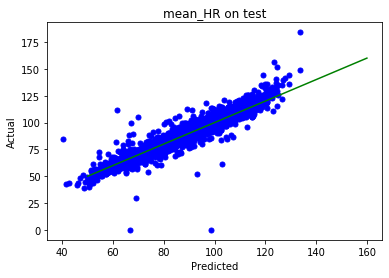

In [37]:
x = np.linspace(50, 160, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on test")
plt.plot(x, x, '-g')
plt.show()

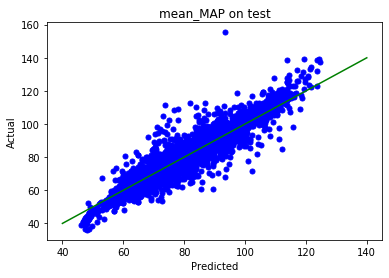

In [38]:
x = np.linspace(40, 140, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on test")
plt.plot(x, x, '-g')
plt.show()

### Lariboisiere predictions

In [39]:
out1, out2, y1, y2 = predict_one_batch(model, test_larib_dl)

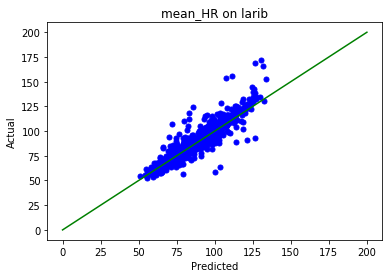

In [40]:
x = np.linspace(0, 200, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on larib")
plt.plot(x, x, '-g')
plt.show()

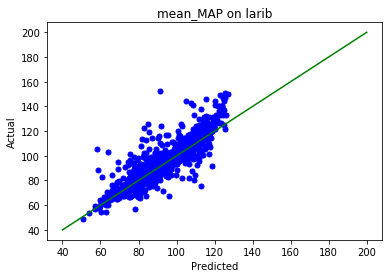

In [41]:
x = np.linspace(40, 200, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on larib")
plt.plot(x, x, '-g')
plt.show()

In [42]:
y1 = np.reshape(y1, (-1,1))
y2 = np.reshape(y2, (-1,1))
arr_hr = np.concatenate((out1, y1) , axis=1)
arr_map = np.concatenate((out2, y2) , axis=1)
periode = np.reshape(test_larib.key.values, (-1,1))
arr_hr = np.concatenate((out1, y1, periode) , axis=1)
arr_map = np.concatenate((out2, y2, periode) , axis=1)
pd.DataFrame(arr_hr).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/larib_obs_pred_HR_15.csv")
pd.DataFrame(arr_map).to_csv("/home/menyssa/Recherche/Mimic-III-Yannet/resultats/2e_analyse/larib_obs_pred_MAP_15.csv")